# FilmForecast
## Project aiming at Predicting Movie Ratings using Methods of Machine Learning

### Topic : Predict the Rating of Movies

#### by:
#### Valentin Straßer (Matrikelnummer: 12345678),
#### Mathusan Saravanapavan (Matrikelnummer: 98765432),
#### Michał Roziel (Matrikelnummer: 11223344)

#### The goal in this project is to predict the rating (vote_average) of movies based on other features (e.g., their release date and box-office revenue).


#### Data :

The TMDB Movies Dataset consists of information about 1 million movies scraped from IMDB. The dataset is available for download from Moodle. More information about the dataset can be found here:

https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/data


#### Goals :

Employing the methods that we covered in the lecture, you should come up with your own solution to the problem and evaluate it. In order to obtain bonus points, you have to submit your solution as a single Jupyter Notebook by August 30, 2025. Your Jupyter notebook should cover the following aspects:

some analysis of the dataset (e.g., statistics regarding its size or the distribution of individual features)
details on any preprocessing that you applied to the dataset (e.g., to clean it up by removing null values)
a detailed description of your approach (e.g., which method to do you use, which features do you consider)
a discussion of the experimental results (e.g., what is the performance that your achieves, how does it compare to other methods)


In [82]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MultiLabelBinarizer, PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("../Database/Dataset.csv")
df_raw = df.copy()  # Keep a backup of the original dataset

In [83]:
df.shape

(1266348, 24)

In [84]:
print(df.columns.tolist())

['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']


### 1. Analysis of the Dataset

The data frame, from iMDB, initially, contains information on 1266865 movies.

#### Initial Look at the DB :

- Size : The original DB has the dimensions : `(1266865, 24)`

- Null Values : With a Threshold of 50 % we identify the columns that contain more than half null values.

- We decided to Drop those as they would not provide reliable features for the model.
- After this step, the dataset was reduced to 19 columns.
- The Ones being Dropped are : ``` 'keywords', 'homepage', 'backdrop_path', 'production_companies', 'tagline' ```

#### Feature Distribution :
- The target variable, `vote_average`, is a continuous variable, which lets us identify this problem as a regression problem.
- Some Features have skewness and need to be Scaled / refactored
- Some cols like `genres` are in a JSON-like format and need to be parsed to be usable as features.
- Some features like `original_language` can be one-hot encoded.


In [85]:
# Initial Data Cleaning - Remove Columns with Too Many Null Values

# 1. Set a threshold for null values (50%).
# Columns with more null values than the threshold will be dropped.
threshold = len(df) * 0.5

# Count null values for each column.
null_counts = df.isnull().sum()


# 2. Identify columns where the null count exceeds the threshold.
cols_to_drop = null_counts[null_counts > threshold].index.tolist()

# 3. Drop the identified columns.
df = df.drop(columns=cols_to_drop)

print("Original shape:", df_raw.shape)
print("Cleaned shape:", df.shape)
print("----------------------------------------\n")

# Check which columns were dropped.
# Use set difference to find the dropped columns.
dropped_cols = set(df_raw.columns) - set(df.columns)
print("Dropped columns:", dropped_cols)
print("----------------------------------------")
print("----------------------------------------")
print("----------------------------------------")
print("Remaining columns:", df.columns.tolist())

Original shape: (1266348, 24)
Cleaned shape: (1266348, 19)
----------------------------------------

Dropped columns: {'production_companies', 'keywords', 'tagline', 'homepage', 'backdrop_path'}
----------------------------------------
----------------------------------------
----------------------------------------
Remaining columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'budget', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'genres', 'production_countries', 'spoken_languages']


In [86]:
# Second Data Cleaning
# Drop columns that are not needed for the model, we cannot predict the rating from cols like title, id, etc. .

#------------------------------
cols_to_drop_for_model = [
    'id',
    'title',
    'original_title',
    'imdb_id',
    'poster_path',
    'overview',
    'vote_average',
    'production_countries', # already using original language and genres
    'spoken_languages' # already using original language
]
#------------------------------

#------------------------------
features = df.drop(columns=cols_to_drop_for_model)
target = df['vote_average']
#------------------------------

#------------------------------
print("Original DataFrame:", df.shape)
print("Features DataFrame:", features.shape)
print("-------------------------------------------")
print("The Features we are going to be using:", features.columns.tolist())
#------------------------------


Original DataFrame: (1266348, 19)
Features DataFrame: (1266348, 10)
-------------------------------------------
The Features we are going to be using: ['vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'budget', 'original_language', 'popularity', 'genres']


In [87]:
# check values in different columns

#print(df['status'].value_counts(dropna=False))
#print(df['adult'].value_counts(dropna=False))
#print(df['original_language'].value_counts())
df['genres'].describe()

count          733267
unique          14126
top       Documentary
freq           147108
Name: genres, dtype: object

### 2. Preprocessing and Feature Engineering

Before training out model we are going to Feature Engineer our data Frame

#### Feature Selection :
- Columns not relevant for prediction  were dropped to create the feature set. The target variable `vote_average` was separated.

- Handling JSON-like Columns (`genres`) :
- We extracted the genre name with a `has_` prefix


#### Feature Transformation and Scaling :

- Logarithmic Scaling : because of broad distribution and skewness of  `vote_count`, we applied a logarithmic transformation.

#### Scaling :
- `MinMaxScaler` was used to scale `budget`, `revenue`
- Normatlization was applied to `budget`, `revenue`

#### Missing values :
- In `runtime` were imputed with the median,
- While `budget` and `revenue` NaNs were filled with 0.
- Date Feature Extraction : The year was extracted from the `release_date` column to create a `release_year` feature

#### Categorical Feature Encoding :
- Status : The `status` column was converted into a binary feature `status_released`
- Original Language : The `original_language` column was converted using one-hot encoding (`pd.get_dummies`).
- Adult : The boolean `adult` column was converted to an binary choice (0 or 1).
- Final Feature Set : The final set of features created by engineering. Any remaining `NaN` values  were filled with 0.

In [88]:
# Split Data into Training, Validation, and Test Sets
# We will use 70% for training, 20% for validation, and 10% for testing.

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


# Splitting the Data into train and temporary sets (70% train, 30% temp).
# Using train_test_split from SCIKIT LEARN
X_train, X_temp, y_train, y_temp = train_test_split(
    # X_train : features
    # X_temp : also features, 30 percent of the data
    # y_train : target
    # y_temp : still 30 percent of the data, but not features -> target values
    features, target,
    test_size=0.30,
    random_state=42 )

# Splitting the Temp set into validation and test sets (50% of temp each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=1/3,
    random_state=42 )

# Display the shapes of the resulting splits to confirm.
print("Training features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Test features shape:", X_test.shape)
print("---")
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Test target shape:", y_test.shape)



Training features shape: (886443, 10)
Validation features shape: (253270, 10)
Test features shape: (126635, 10)
---
Training target shape: (886443,)
Validation target shape: (253270,)
Test target shape: (126635,)


In [89]:
scaler_runtime = MinMaxScaler()
scaler_br = MinMaxScaler()
scaler_pop = MinMaxScaler()

def feature_engineer(X_train, X_val, X_test):

  #  We Apply feature engineering to the sets :TRAIN, VAL, TEST


    # Create copies to avoid modifying the original DataFrames
    x_train_eng = X_train.copy()
    x_val_eng = X_val.copy()
    x_test_eng = X_test.copy()

    # --- Transformations we are going to use ---
    for df_split in [x_train_eng, x_val_eng, x_test_eng]:

        #------------------------------
        # Convert VOTE_COUNT using logarithmic scaling
        # prevents extreme large values
        # Log transform VOTE_COUNT
        df_split['vote_count_log'] = np.log1p(df_split['vote_count'])
        #------------------------------


        #------------------------------
        # One-hot encode 'status'
        df_split['status_released'] = (df_split['status'] == 'Released').astype(int)
        # By Far the majority of movies are Released -> Binary Choice
        # 1 : Released, 0 : Not Released
        #------------------------------


        #------------------------------
        # Convert 'release_date' to datetime and extract the YEAR
        df_split['release_date'] = pd.to_datetime(df_split['release_date'], errors='coerce')
        df_split['release_year'] = df_split['release_date'].dt.year
        df_split['release_year'] = df_split['release_year'].clip(upper=2025, lower=1900)
        #------------------------------


        #------------------------------
        # Convert ADULT to binary (1 for True, 0 for False).
        # This is statistically relevant, as almost 10% of movies are for adults.
        # Convert ADULT to binary
        df_split['adult'] = df_split['adult'].astype(bool).astype(int)
        #------------------------------

        #------------------------------
        # GENRES : (clean comma+space separated) -> one-hot "has_*" columns
        genre_dummies = df_split['genres'].fillna('').str.get_dummies(sep=', ').add_prefix('has_')
        for col in genre_dummies.columns:
            df_split[col] = genre_dummies[col]
        #------------------------------

    # --- Fit on training data, then transform all sets ---

    #------------------------------
    # Convert RUNTIME to numeric, fill NaN with median.
    runtime_median = x_train_eng['runtime'].median()
    for df_split in [x_train_eng, x_val_eng, x_test_eng]:
        # FIX: Avoid inplace=True
        df_split['runtime'] = df_split['runtime'].fillna(runtime_median)
    #------------------------------

    #------------------------------
    # We are Scaling the three RUNTIME sets
    x_train_eng['runtime_scaled'] = scaler_runtime.fit_transform(x_train_eng[['runtime']])
    x_val_eng['runtime_scaled'] = scaler_runtime.transform(x_val_eng[['runtime']])
    x_test_eng['runtime_scaled'] = scaler_runtime.transform(x_test_eng[['runtime']])
    #------------------------------


    #------------------------------
    # FILL missing BUDGET and REVENUE
    for df_split in [x_train_eng, x_val_eng, x_test_eng]:
        # FIX: Avoid inplace=True
        df_split['budget'] = df_split['budget'].fillna(0)
        df_split['revenue'] = df_split['revenue'].fillna(0)

    # Scale BUDGET and REVENUE between 0 and 1.
    x_train_eng[['budget_scaled', 'revenue_scaled']] = scaler_br.fit_transform(x_train_eng[['budget', 'revenue']])
    x_val_eng[['budget_scaled', 'revenue_scaled']] = scaler_br.transform(x_val_eng[['budget', 'revenue']])
    x_test_eng[['budget_scaled', 'revenue_scaled']] = scaler_br.transform(x_test_eng[['budget', 'revenue']])
    #------------------------------


    #------------------------------
    # Scale 'popularity'
    x_train_eng['popularity_scaled'] = scaler_pop.fit_transform(x_train_eng[['popularity']])
    x_val_eng['popularity_scaled'] = scaler_pop.transform(x_val_eng[['popularity']])
    x_test_eng['popularity_scaled'] = scaler_pop.transform(x_test_eng[['popularity']])
    #------------------------------

    #------------------------------
    # One-hot encode 'original_language'
    x_train_eng = pd.get_dummies(x_train_eng, columns=['original_language'], prefix='lang', drop_first=True)
    x_val_eng = pd.get_dummies(x_val_eng, columns=['original_language'], prefix='lang', drop_first=True)
    x_test_eng = pd.get_dummies(x_test_eng, columns=['original_language'], prefix='lang', drop_first=True)
    #------------------------------

    # --- //FIX: Align columns - -fix ---
    # https://stackoverflow.com/questions/37981678/
    train_cols = x_train_eng.columns
    x_val_eng = x_val_eng.reindex(columns=train_cols, fill_value=0)
    x_test_eng = x_test_eng.reindex(columns=train_cols, fill_value=0)
    # --- //FIX ---

    # --- Define  feature columns for GENRE and LANGUAGE ---
    genre_features = [col for col in x_train_eng.columns if col.startswith('has_')]
    lang_features = [col for col in x_train_eng.columns if col.startswith('lang_')]

    #------------------------------
    # FINAL FEATURE COLUMNS
    #------------------------------
    feature_cols = [
        'vote_count_log', 'status_released', 'release_year',
        'budget_scaled', 'revenue_scaled', 'runtime_scaled',
        'adult', 'popularity_scaled'
    ] + genre_features + lang_features
    #------------------------------

    #------------------------------
    # if still missing values, fill with 0
    #------------------------------
    # Select and fill any remaining NaNs in the final feature sets
    x_train_final = x_train_eng[feature_cols].fillna(0)
    x_val_final = x_val_eng[feature_cols].fillna(0)
    x_test_final = x_test_eng[feature_cols].fillna(0)
    #------------------------------

    return x_train_final, x_val_final, x_test_final

In [90]:
# Apply the function to your data splits
X_train, X_val, X_test = feature_engineer(X_train, X_val, X_test)

# Display the shape of the processed data to confirm
print("Processed training features shape:", X_train.shape)
print("Processed validation features shape:", X_val.shape)
print("Processed test features shape:", X_test.shape)

Processed training features shape: (886443, 198)
Processed validation features shape: (253270, 198)
Processed test features shape: (126635, 198)


### 3. Possible modeling Scenarios

To predict the movie ratings, we tried out several regression models. The data was split into training (70%), validation (20%), and test (10%) sets to train the models and evaluate their performance on unseen data, which helps in preventing overfitting.

The following models were considered:
1.  **Linear Regression**: A simple baseline model to establish initial performance.
2.  **Ridge Regression**: An extension of linear regression that includes L2 regularization to reduce model complexity and prevent overfitting.
3.  **Polynomial Regression**: This approach transforms features into polynomial terms to capture non-linear relationships between the features and the movie rating.



In [91]:
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Test target shape:", y_test.shape)


Training set shape: (886443, 198)
Validation set shape: (253270, 198)
Test set shape: (126635, 198)
Training target shape: (886443,)
Validation target shape: (253270,)
Test target shape: (126635,)


In [92]:
# Check for object (non-numeric) dtypes
print(features.dtypes[features.dtypes == 'object'])

# Check for missing values
print("NaNs in features:", features.isna().sum().sum())
print("NaNs in target:", target.isna().sum())

status               object
release_date         object
original_language    object
genres               object
dtype: object
NaNs in features: 777205
NaNs in target: 0


In [93]:
# FUNCTION FOR LINEAR REGRESSION
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
def execute_linear_regression():
# Initialize model
    model = LinearRegression()

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train) # Predict on training set
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Return predictions and model
    return y_train_pred, y_val_pred, y_test_pred

In [94]:
# FUNCTION FOR RIDGE REGRESSION

def execute_ridge_regression():


# Initialize Ridge model.
# alpha: Regularization strength (default = 1.0).
    model = Ridge()

# Train the model.
    model.fit(X_train, y_train)

# Predictions.
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    return y_val_pred, y_test_pred

In [95]:
# FUNCTION FOR POLYNOMIAL REGRESSION
def execute_polynomial_regression():

# Initialize model.
    model = LinearRegression()

# Select numeric features for polynomial transform; not too many to avoid heavy workload.
    numeric_features = ['vote_count_log', 'budget_scaled', 'revenue_scaled', 'runtime_scaled', 'popularity_scaled']

# Create subsets for training, validation, and testing.
    x_train_num = X_train[numeric_features]
    x_val_num = X_val[numeric_features]
    x_test_num = X_test[numeric_features]


# Create Polynomial Features of degree 2.
    poly = PolynomialFeatures(degree=2, include_bias=False)

# Here, we create polynomial features for the numeric columns.
# .to_numpy() is not needed here as fit_transform handles it.
    x_train_poly = poly.fit_transform(x_train_num)
    x_val_poly = poly.transform(x_val_num)
    x_test_poly = poly.transform(x_test_num)

# Use set difference to obtain features that are not numeric.
    x_train_other = X_train.drop(columns=numeric_features)
    x_val_other = X_val.drop(columns=numeric_features)
    x_test_other = X_test.drop(columns=numeric_features)

# Combine polynomial numeric features with the rest.
# hstack combines the arrays horizontally.
# here, .to_numpy() is needed to convert DataFrames to NumPy arrays.
    x_train_final = np.hstack([x_train_poly, x_train_other.to_numpy()])
    x_val_final = np.hstack([x_val_poly, x_val_other.to_numpy()])
    x_test_final = np.hstack([x_test_poly, x_test_other.to_numpy()])

# Train the model.

    model.fit(x_train_final, y_train)

# Predict target features for validation and test sets.
    y_val_pred = model.predict(x_val_final)
    y_test_pred = model.predict(x_test_final)

# Return predictions.
    return y_val_pred, y_test_pred

In [96]:
# Run the chosen model
# Available models are:
# 1. Linear Regression
# 2. Ridge Regression
# 3. Polynomial Regression (Linear Regression using Polynomial Features)
y_train_pred, y_val_pred, y_test_pred = execute_linear_regression()

# Clip predictions to the valid range [0, 10]
y_train_pred = np.clip(y_train_pred, 0, 10)
y_val_pred = np.clip(y_val_pred, 0, 10)
y_test_pred = np.clip(y_test_pred, 0, 10)


# Now we can look at how well the chosen model performs.

# R² score
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mean Squared Error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("📊 Training R2:", r2_train)
print("----------------------")
print("📊 Validation R2:", r2_val)
print("----------------------")
print("📊 Test R2:", r2_test)
print("----------------------")
print("📉 Training MSE:", mse_train)
print("----------------------")
print("📉 Validation MSE:", mse_val)
print("----------------------")
print("📉 Test MSE:", mse_test)
print("----------------------")


📊 Training R2: 0.5220842521993403
----------------------
📊 Validation R2: 0.5228928690368161
----------------------
📊 Test R2: 0.5213565701276246
----------------------
📉 Training MSE: 4.143648140150838
----------------------
📉 Validation MSE: 4.125576312896432
----------------------
📉 Test MSE: 4.1473302423112575
----------------------


In [97]:


# Create a DataFrame with predictions, actuals, and titles.
results = pd.DataFrame({

    # take the correct movie title
    'title': df.loc[X_test.index, 'title'],

    'predicted_rating': y_test_pred,

    'actual_rating': y_test
})

# Round values for easier reading.
results['predicted_rating'] = results['predicted_rating'].round(2)
results['actual_rating'] = results['actual_rating'].round(2)

res_non_zero = results[results['actual_rating'] > 0]

# Show a random sample of 20 movies.
sample_results = res_non_zero.sample(20, random_state=42)

display(sample_results)

,title,predicted_rating,actual_rating
149966,Fatcap Express,3.34,7.00
72340,Obra 67,5.93,5.60
196962,My Childhood in Hell,3.27,7.00
79422,"We'll Kick Up a Fuss Tomorrow, Darling...",5.16,8.11
320506,The Other Also,1.93,5.00
170349,Olesya,3.60,7.00
301805,Seconds,2.02,10.00
287907,KODA KUMI 10th Anniversary ～FANTASIA～in TOKYO ...,2.10,10.00
4055,Sleeping with the Enemy,10.00,6.48
296904,Outward Bound,2.34,10.00


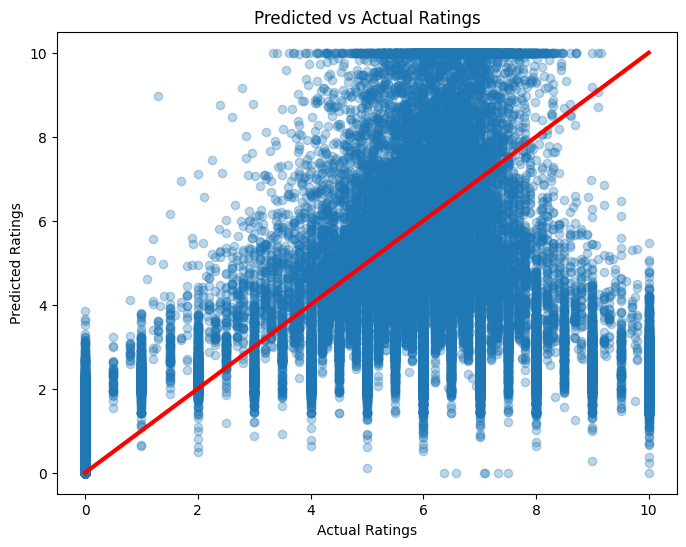

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.plot([0, 10], [0, 10], 'r', lw=3)  # Perfect prediction line
plt.show()